In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
#import seaborn as sns
import dynamic_stock_model as dsm

In [2]:
# Loading data
path = os.getcwd()
data = pd.read_csv(path+"/old_model/dummy_data_battery.csv", header=0 , sep=',')
# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)

# We store the time and inflows values in two lists
time = data['Time'].tolist()
stock_cars = data['Population'].tolist() # FIXME: Is he stock just labeled wrongly as population or is it intended this way?
years = len(time)

## Case 1
Cars have a lifetime that includes all types of failures, battery EoL being one of them. No battery replacement. 1 car = one battery, Outflow battery = outflow car 

Since this case includes all possible failures, the choice of lifetime should not be limted to the technical lifetime of the vehicle itself but should also consider how this might be affected by failures in the battery and vehicle crashes. Therefore, the probability that a failure occurs is greater than the techical lifetime of the vehicle itself and leads to a shorter choice of lifetime. 

This is a simpler and less explicit method for accounting for failures of both products with a single lifetime. 

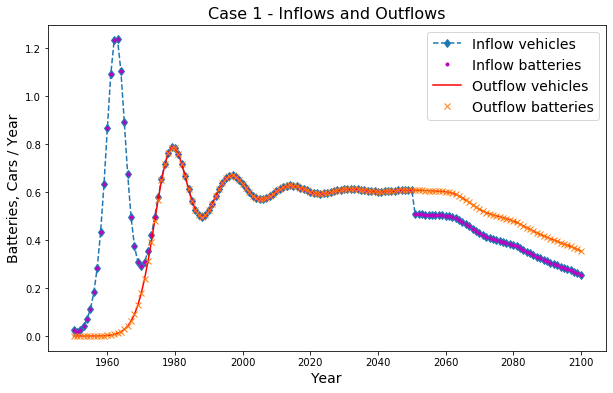

In [4]:
import product_component_model as pcm
Model1 = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)

Model1.case_1()
# Inflows and Outflows for the battery model
plt.figure(figsize=(10, 6))
plt.plot(time, Model1.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model1.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model1.oc_pr.sum(axis=1),'r', label='Outflow vehicles')
plt.plot(time, Model1.oc_cm.sum(axis=1),'x', label='Outflow batteries')
plt.title('Case 1 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 2
Cars have a lifetime that includes all types of failures, battery EoL being one of them. Still, it is assumed that some batteries will be replaced at a given rate. More than one battery in the lifetime of the car. Outflow battery >= outflow car

In this case the failure of batteries is accounted for by a replacement rate and therefore the lifetime of the vehicle can be assumed to not be affected to the same extent as in case 1. Limitations to this approach might be that the outflows and battery inflows are estimated at different times as the case where a separate lifetime would be calculated for the batteries. It is more suitable if the stock is approximately constant. 

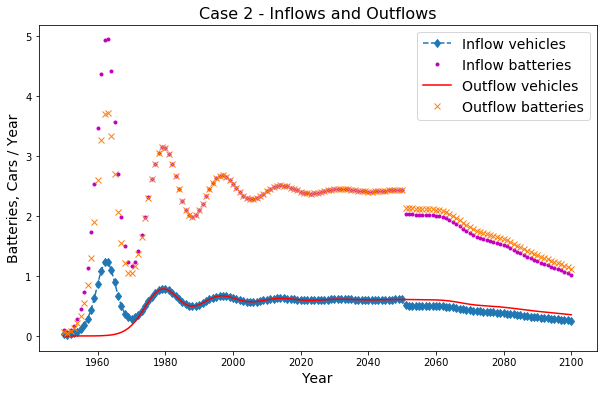

In [6]:
Model1 = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model1.case_2()
# Inflows and Outflows for the battery model
plt.figure(figsize=(10, 6))
plt.plot(time, Model1.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model1.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model1.o_pr,'r', label='Outflow vehicles')
plt.plot(time, Model1.o_cm,'x', label='Outflow batteries')
plt.title('Case 2 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 3

Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can neither be replaced nor reused, meaning that if either the car or the battery fail, they are both scrapped.

In this case, the combined lifetimes of the battery and the car yield a smaller effective lifetime that dictates the outflows based on all failures. This would be a similar case as 1, but the effective lifetime choice is more explicit and potentially more robust, since it considers aspects of both products. 

Since now we have two pdf curves causing the outflows, the commulative probability of the pdf curve is greater than 1. Therefore, we need to aggregate the two lifetimes and create a combined one. 

A different battery lifetime is chosen here to better illustrate the case. 

/Users/fernaag/Box/BATMAN/Coding/product_component_model/product_component_model.py:346: RuntimeWarning: invalid value encountered in true_divide
  self.hz_cm [m+1:,m] = (self.sf_cm[m:-1,m] - self.sf_cm[m+1::,m]) / self.sf_cm[m:-1,m]


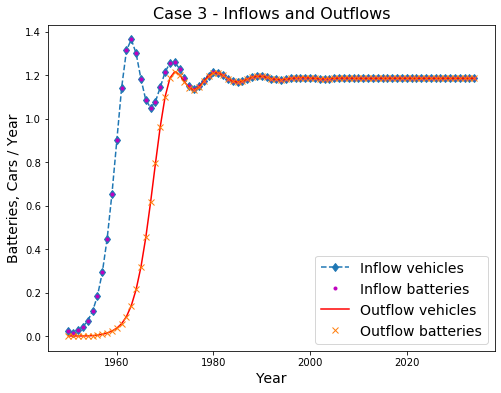

In [8]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_3()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow vehicles')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
plt.title('Case 3 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 4 
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries cannot be replaced, but they can be reused. If the battery fails, the car is scrapped. If the car fails but the status of the battery is still good, it can be reused in a new car (we call this reuse rate R in the table). This case does not necessarily make sense for cars, but could be useful for other applications.

To determine the amount of batteries that have gone out, we take the outflows due to vehicle failures and use the probability of the battery still being useful from the battery survival function with a delay tau to ensure that we don't reuse batteries that will fail soon anyway. Since we attribute simultanious failures to the batteries anyway, we should be onm the conservative side of the potential batteries for reuse. 

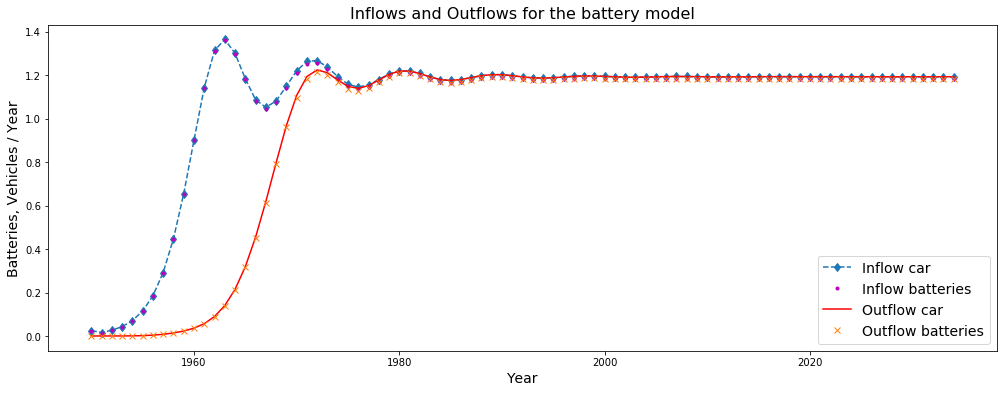

In [9]:
import product_component_model as pcm
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_4()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Vehicles / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 5
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can be replaced, but they cannot be reused. If the car fails, the battery is scrapped. If the battery fails but the car is still in good shape, a new battery can be used to make the car operational again. Since the lifetimes of the car and the batteries are independent, replacing the battery should have no effect on the car’s lifetime. 

In this case the lifetime of the car is not limited by the lifetime of a battery. Without an additional logic, this means that battery replacements will always happen to allow the vehicle to live the full extent of it's expected lifetime. As a consequence, there can be batteries that are barely used in the fleet that are being scrapped wiht the vehicle. To avoid this, we could again rely on the survival function to only replace batteres that are either under warranty or that will stay in the fleet for a reasonable amount of time. 

We need to replace the batteries that are failing and put new ones in vehicles that are still in the fleet. Since there are some vehicles that fail simultainiously as the batteries, we should not replace all of the battery attributed outflows. We therefore attribute the simultanious failures to vehicles instead of batteries and use the sf of the batteries as a share of batteres that would still be in good condition for reused

The batteries are put in vehicles of the same cohort or older. Newer cohorts cannot get older batteries. 

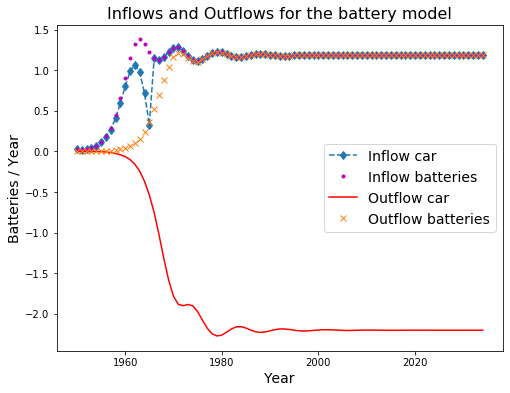

In [12]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_5()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 6
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can be replaced and/or reused. If the car fails but the status of the battery is still good, the battery can be reused in another car. If the battery fails but the car is still in good shape, a new battery can be used to make the car operational again. Since the lifetimes of the car and the batteries are independent, replacing the battery should have no effect on the car’s lifetime. Similarly, a battery that is reused in another car keeps its age and lifetime. Such a model would probably use parameters and transfer coefficients to determine the share of cars and batteries that will be reused depending on their age.

Assuming that all batteries that flow out in the vehicles are reusable would lead to an overestimation of the amount of batteries that are actually fit to be reused. Instead, a logic is needed here to make a reasonable assumption. We reuse only the share of batteries that would be still be usable according to their own technical lifetime. This logic can be further developed to use only the share of batteries that will be still useful for a specified minimum amount of time tau. 

As a first priority, vehicles will get a replacement from reused batteries. If these are not enough, new batteries fill the gap. 

In [13]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_6()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

/Users/fernaag/Box/BATMAN/Coding/product_component_model/product_component_model.py:346: RuntimeWarning: invalid value encountered in true_divide
  self.hz_cm [m+1:,m] = (self.sf_cm[m:-1,m] - self.sf_cm[m+1::,m]) / self.sf_cm[m:-1,m]


KeyboardInterrupt: 

## Case 7
The model does not use lifetimes at all. It would make sense if the inflows of cars and batteries are calculated as a percentage of the stock (Stock and birth rate model in the paper with Dirk). OK for models where the stock is stable, not suited for studying the penetration of new products and technologies. 1 car = 1 battery, no replacement allowed

This type of models can be driven by either a death or a birth rate. The battery outflows and the vehicle outflows are equivalent and the rate encompases failures in both products. 

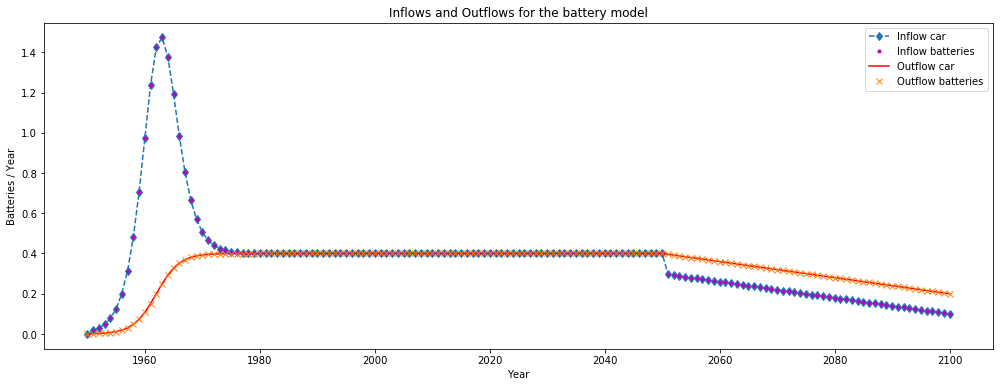

In [14]:
import product_component_model as pcm
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_7()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

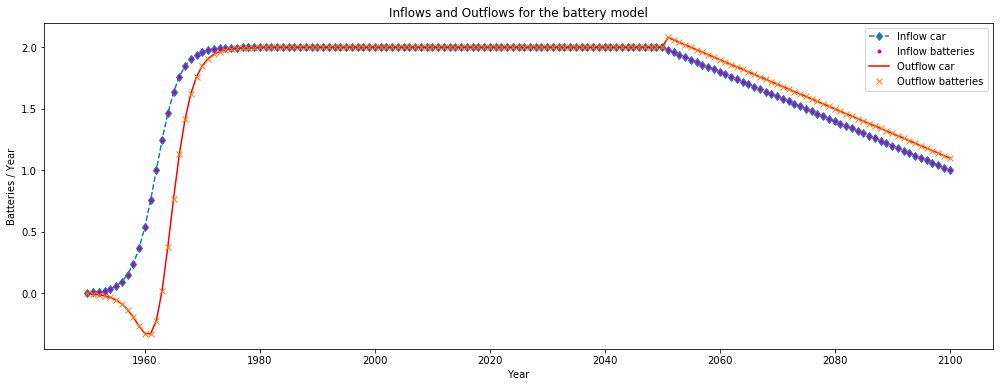

In [17]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3, b=0.2)
Model.case_7b()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 8	
The model does not use lifetimes at all. It would make sense if the inflows of cars and batteries are calculated as a percentage of the stock (Stock and birth rate model in the paper with Dirk). OK for models where the stock is stable, not suited for studying the penetration of new products and technologies.

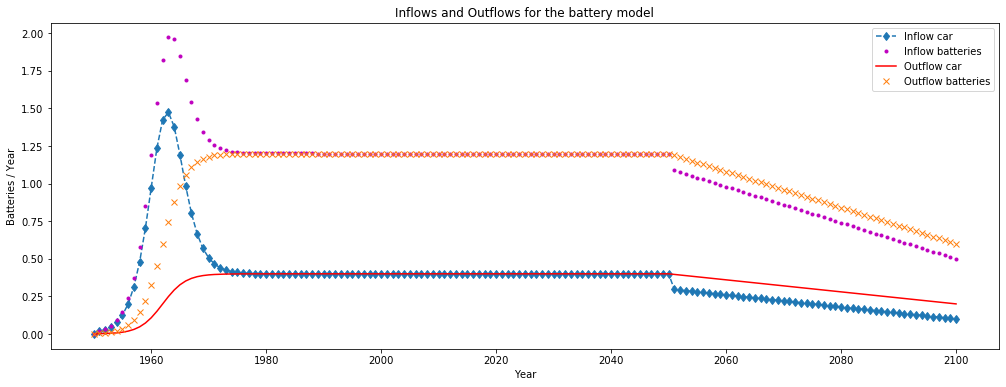

In [18]:
Model = Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_8()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 9
The lifetime of the car is mostly determined by the lifetime of the battery. No battery replacement, when it dies, the car dies.  There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. 1 car = one battery, Outflow battery = outflow car.  

Since the vehicle lifetime is defined by the battery lifetime and there is no replacement, we can model moth producs as in case 1 with the battery lifetime instead of the vehicle lifetime. 

/Users/fernaag/Box/BATMAN/Coding/product_component_model/product_component_model.py:346: RuntimeWarning: invalid value encountered in true_divide
  self.hz_cm [m+1:,m] = (self.sf_cm[m:-1,m] - self.sf_cm[m+1::,m]) / self.sf_cm[m:-1,m]


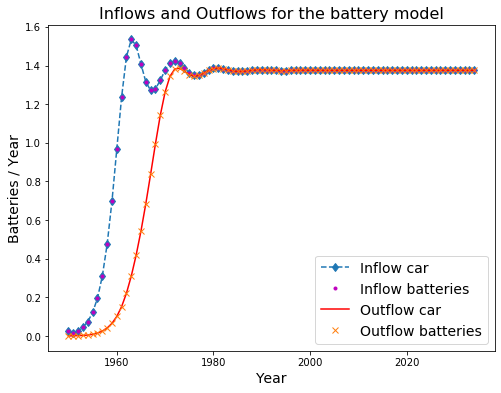

In [19]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_9()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 10 
The lifetime of the car is mostly determined by the lifetime of the battery. No battery replacement, when it dies, the car dies, but some batteries from crashed cars can be reused in new cars.  There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery <= outflow car. This case is probably not the most meaningful.

In this case some of the batteries are deemed to be reusable. This makes sense if we consider that some of the outflows are due to vehicle failures. We can here consider then that only a fraction of the batteries that would qualify can actually be reused. Therefore, we define the survival curve of the battery and consider that only the share of batteries that would still be there after a certain amount of years theoretically qualifies for reuse, but because some of those batteries are in fact faulty, a factor is needed in addition. 

85  too many components to reuse
86  too many components to reuse
87  too many components to reuse
88  too many components to reuse
89  too many components to reuse
90  too many components to reuse
91  too many components to reuse
92  too many components to reuse
93  too many components to reuse
94  too many components to reuse
95  too many components to reuse
96  too many components to reuse
97  too many components to reuse
98  too many components to reuse
99  too many components to reuse
100  too many components to reuse
101  too many components to reuse
102  too many components to reuse
103  too many components to reuse
104  too many components to reuse
105  too many components to reuse
106  too many components to reuse
107  too many components to reuse
108  too many components to reuse
109  too many components to reuse
110  too many components to reuse
111  too many components to reuse
112  too many components to reuse
113  too many components to reuse
114  too many components to r

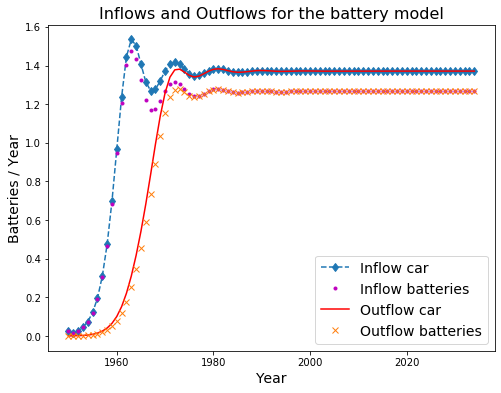

In [20]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_10()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 11
The lifetime of the car is mostly determined by the lifetime of the battery. The battery can be replaced, but old batteries cannot be reused. This model assumes that a car would live infinitely as long as the battery keeps being replaced.There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery >= outflow car. 

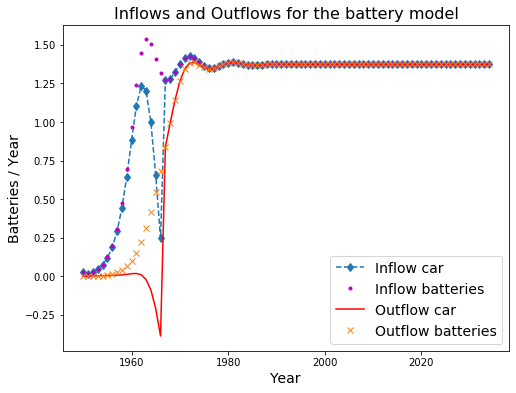

In [21]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_11()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 12
The lifetime of the car is mostly determined by the lifetime of the battery. The battery can be replaced, and old batteries can be reused. This model assumes that a car would live infinitely as long as the battery keeps being replaced. There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery <= or >= outflow car depending on assumptions for reuse and replacement.

We take a similar approach to case 6 here, only the cars do not have a lifetime and therefore are always elegible to get a battery replacement. The rules for when a battery can be reused become more tricky because we now assume that pretty much all outflows are because of battery failured. So what we do is take the share of batteries that is exiting the fleet due to vehicle crashes and take a share of them for reuse. Since there is a leaching approach, we do not know the cohort of the vehicles being crashed and therefore we have to assume that the batteroes will be fit for reuse for a full battery lifetime. 

In [22]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=3)
Model.case_12()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='I nflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

KeyboardInterrupt: 